In [27]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pylab as plt
%matplotlib inline


D:\anaconda_py3\python3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
yield_data = pd.read_csv('FRB_H15.csv').replace('ND',np.nan).dropna(axis=0,how='any')
yield_data['Time Period'] = pd.to_datetime(yield_data['Time Period'])
yield_data['Day of week'] = yield_data['Time Period'].dt.dayofweek
#derive is weekend
yield_data['IS_WEEKEND'] = 1
weekend = yield_data['IS_WEEKEND'].copy()
weekend[(yield_data['Day of week'] != 5) & (yield_data['Day of week'] != 6)] = 0
yield_data['IS_WEEKEND'] = weekend
yield_data.set_index('Time Period',inplace=True)
yield_data.index.name = None
#kickout weekend data
yield_data=yield_data.query('IS_WEEKEND==0')
#cut off data 2010 onwards,but for rolling window of 30 we need '09 dec data
yield_data = yield_data[yield_data.index >'2009-11-30']

In [4]:
np.random.seed(7)
# missing_col = np.random.choice(yield_data.columns,3)
missing_col = yield_data.columns
missing_col

Index(['1-month', '3-month', '6-month', '1-year', '2-year', '3-year', '5-year',
       '7-year', '10-year', '20-year', '30-year', 'Day of week', 'IS_WEEKEND'],
      dtype='object')

In [5]:
for i in missing_col:
    yield_data[i] = \
    [d if l else np.nan for d, l in zip(yield_data[i], np.random.choice([True,False],size=yield_data.shape[0], p=[0.7,0.3]))]

In [6]:
yield_data.head()

,1-month,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,20-year,30-year,Day of week,IS_WEEKEND
2009-12-01,0.09,NaN,NaN,0.26,0.67,1.14,NaN,2.74,3.28,4.14,4.26,NaN,0.0
2009-12-02,NaN,NaN,NaN,0.28,NaN,NaN,2.09,2.8,NaN,4.14,4.26,2.0,0.0
2009-12-03,0.09,0.06,NaN,0.3,0.74,1.23,2.14,2.87,3.39,4.23,NaN,NaN,NaN
2009-12-04,NaN,NaN,0.17,0.36,NaN,1.34,2.24,2.97,3.48,4.31,NaN,4.0,0.0
2009-12-07,NaN,0.04,NaN,0.32,0.78,1.26,2.19,2.92,3.44,NaN,4.4,0.0,0.0


In [7]:
yield_data_filtered = yield_data

In [8]:
def rolling_method(df,col,window):
    method = ['mean','std','median','min','max']
    a = df[col].rolling(window=window, min_periods = 1)
    b = pd.concat([getattr(a,k)() for k in method],axis=1)
    b.columns  = method
    #b['RMS'] = a.apply(lambda y: np.sqrt(np.mean(y**2)))
    #b['crest'] = 0.5*(b['max']-b['min'])/b['RMS']
    #b['crossing'] = a.apply(lambda y: len(np.where(np.diff(y - np.mean(y)))[0]))/window
    #b['slope'] = a.apply(lambda y: linregress(range(window),y)[0])
    b.columns = [col + '_'+ k +'_'+str(window)+'day' 
                 for k in ['mean','std','median','min','max'#,'RMS','crest','crossing','slope'
                          ]]
    return b

In [10]:
yield_data_features=pd.concat([rolling_method(yield_data_filtered,i,j) \
                               for i in yield_data_filtered.columns[:11] \
                               for j in [3,7,15,20]],axis=1).shift(11) 
# 11 beacuse first shift 1 and then shift 10 as rolling window of 20 from 10th to 30th day
yield_data_features.head(100)

,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,30-year_mean_15day,30-year_std_15day,30-year_median_15day,30-year_min_15day,30-year_max_15day,30-year_mean_20day,30-year_std_20day,30-year_median_20day,30-year_min_20day,30-year_max_20day
2009-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#MCMC fill the missing value
#Temporarily fill the missing value with previous day and ensure the last day is not nan
data = yield_data
data_temp = data.fillna(method='ffill',inplace=False)
data_temp = data_temp.fillna(method='bfill')
data_temp = pd.DataFrame(data_temp,dtype=np.float32)
data = pd.DataFrame(data,dtype=np.float32)
data_diff = (data_temp - pd.rolling_mean(data_temp,100))
data.iloc[-1,:] = data_temp.iloc[-1,:]

D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100,center=False).mean()
  


In [46]:
sum(pd.isnull(data['1-month']))

569

In [48]:
data

,1-month,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,20-year,30-year,Day of week,IS_WEEKEND
2009-12-01,0.09,NaN,NaN,0.26,0.67,1.14,NaN,2.74,3.28,4.14,4.26,NaN,0.0
2009-12-02,NaN,NaN,NaN,0.28,NaN,NaN,2.09,2.80,NaN,4.14,4.26,2.0,0.0
2009-12-03,0.09,0.06,NaN,0.30,0.74,1.23,2.14,2.87,3.39,4.23,NaN,NaN,NaN
2009-12-04,NaN,NaN,0.17,0.36,NaN,1.34,2.24,2.97,3.48,4.31,NaN,4.0,0.0
2009-12-07,NaN,0.04,NaN,0.32,0.78,1.26,2.19,2.92,3.44,NaN,4.40,0.0,0.0
2009-12-08,0.02,0.03,0.15,0.29,0.73,1.21,2.12,2.86,3.40,NaN,4.39,1.0,NaN
2009-12-09,0.01,NaN,0.14,0.31,NaN,1.23,2.15,NaN,3.45,4.31,4.41,2.0,0.0
2009-12-10,0.01,0.02,0.15,0.32,0.78,NaN,NaN,2.95,3.49,4.37,4.50,3.0,0.0
2009-12-11,0.01,0.03,NaN,0.35,0.83,1.30,2.26,NaN,3.55,4.39,4.49,4.0,0.0
2009-12-14,0.02,NaN,0.16,NaN,NaN,1.35,2.30,3.04,NaN,4.39,NaN,NaN,0.0


In [22]:
#MCMC Functions
#Define starting values 
def get_starting_values(ar_order, data, missing_id):
    
    '''
    Let staring value of missing value xh be the previous day value
    Fill the missing value by the previous day value to fit an AR(p) model, and use the coefficients of this model
    as the starting values of φ and σ^2
    '''
    data_temp = np.array(data)
    xh_start = data_temp[(missing_id-1)]
    
    data_temp[missing_id] = xh_start
    
    model = ARIMA(data_temp, order=(ar_order,0,0))
    
    model_fit = model.fit(trend='nc') #don't include constant term when fit
    
    phi_start = list(model_fit.arparams)
    sigma_start = model_fit.sigma2
    
    
    return (xh_start,phi_start,sigma_start)
    
def gibbs_sampling(n_iter, data, missing_id, ar_order):
    data_temp = np.array(data)
    data_temp[missing_id] = np.nan
    
    phi = []
    sigma = []
    xh = []
    
    #Define hyperparameters
    phi_0 = 0
    sigma_0_phi = 0.25
    miu_0 = 0
    sigma_0_xh = np.nanvar(data_temp)
    v = 10
    lambda_ = 0.05
    
    #Get starting values
    xh_start, phi_start, sigma_start = get_starting_values(ar_order, data, missing_id)
    
    
    phi_temp = phi_start[0] #AR(1)
    data_temp[missing_id] = xh_start
    sigma_temp = sigma_start
    
    for t in range(n_iter):
        #update phi_temp
        sigma_phi_temp = ((np.sum(np.square(data_temp[:-1]))/sigma_temp)+(sigma_0_phi)**-1)**-1
        miu_phi_temp = ((sum(data_temp[:-1]*data_temp[1:])/sigma_temp) + ((sigma_0_phi)**-1)*phi_0 )* sigma_phi_temp

        phi_temp = np.random.normal(miu_phi_temp, sigma_phi_temp)
        phi.append(phi_temp)
        
        #update sigma_temp
        sigma_temp = (v*lambda_ + np.sum(np.square(data_temp[1:]-phi_temp*data_temp[:-1])))/np.random.chisquare(v+len(data_temp)-1)

        sigma.append(sigma_temp)
        
        #update xh temp and data
        miu_xh_temp = (sigma_temp*miu_0+sigma_0_xh*phi_temp*(data_temp[missing_id-1]+data_temp[missing_id+1]))/(sigma_temp+sigma_0_xh*(1+phi_temp**2))
        sigma_xh_temp = (sigma_temp*sigma_0_xh)/(sigma_temp+sigma_0_xh*(1+phi_temp**2))
        
        xh_temp = np.random.normal(miu_xh_temp, sigma_xh_temp)

        data_temp[missing_id] = xh_temp
        xh.append(xh_temp)
        
    return phi,sigma,xh


In [23]:
def MCMC_filling(diff,true,column_name):
    series_temp = diff
    series_true = true
    
    missing_index_time = series_true[pd.isnull(series_true)].index
    series_index = series_true.index
    missing_index=[]
    for t in missing_index_time:
        missing_index.append(series_index.get_loc(t))
    
    predictions = []

    train_temp = list(series_temp)

    for m in missing_index:
        phi,sigma,prediction = gibbs_sampling(2100,train_temp,m,1)
        yhat = np.mean(np.array(prediction)[100:]) #discard first 100 iterations

    
        predictions.append(yhat)
        
    i=0
    for t in missing_index:
        series_true.iloc[t] = predictions[i]+pd.rolling_mean(data_temp,100).loc[missing_index_time[i]][column_name]
        i+=1

    return series_true

In [49]:
#imputed_data = {}


for bond in data.columns[3:11]:
    bond_temp = data_diff[bond].iloc[100:,]
    bond_true = data[bond].iloc[100:,]
    
    bond_true = MCMC_filling(bond_temp,bond_true,bond)
    
    imputed_data[bond] = bond_true
    
    
    print ('finish '+bond)


D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100,center=False).mean()


finish 1-year


D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


finish 2-year
finish 3-year
finish 5-year


D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


finish 7-year


D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


finish 10-year


D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

finish 20-year


D:\anaconda_py3\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


finish 30-year


In [50]:
imputed_data= pd.DataFrame(imputed_data,dtype = np.float32)

In [51]:
imputed_data

,1-month,1-year,10-year,2-year,20-year,3-month,3-year,30-year,5-year,6-month,7-year
2010-04-26,0.140000,0.470000,3.830000,1.090000,4.419150,0.151963,1.670000,4.670000,2.600000,0.250496,3.158706
2010-04-27,0.140000,0.420000,3.710000,1.030000,4.400000,0.157589,1.550000,4.560000,2.597612,0.240000,3.140000
2010-04-28,0.139551,0.430000,3.800000,1.030000,4.470000,0.160000,1.563570,4.630000,2.597937,0.240000,3.230000
2010-04-29,0.150000,0.420000,3.745087,0.998559,4.470298,0.170000,1.580000,4.600000,2.514644,0.230000,3.190000
2010-04-30,0.140000,0.418369,3.690000,0.970000,4.470384,0.160000,1.510000,4.530000,2.430000,0.250000,3.174928
2010-05-03,0.098371,0.418677,3.720000,1.000000,4.373032,0.170000,1.500060,4.530000,2.470000,0.250000,3.160000
2010-05-04,0.061389,0.404478,3.630000,0.960000,4.270000,0.157874,1.490000,4.464013,2.380000,0.233570,3.083158
2010-05-05,0.061415,0.390000,3.524875,0.859637,4.230000,0.150000,1.384041,4.390000,2.310000,0.220000,3.000000
2010-05-06,0.060000,0.340000,3.410000,0.750000,4.030000,0.110000,1.270000,4.340579,2.130000,0.214383,2.830000
2010-05-07,0.080000,0.380000,3.450000,0.830000,4.110000,0.134187,1.320000,4.280000,2.170000,0.210000,2.870000


In [52]:
def rolling_method(df,col,window):
    method = ['mean','std','median','min','max']
    a = df[col].rolling(window=window, min_periods = 1)
    b = pd.concat([getattr(a,k)() for k in method],axis=1)
    b.columns  = method
    #b['RMS'] = a.apply(lambda y: np.sqrt(np.mean(y**2)))
    #b['crest'] = 0.5*(b['max']-b['min'])/b['RMS']
    #b['crossing'] = a.apply(lambda y: len(np.where(np.diff(y - np.mean(y)))[0]))/window
    #b['slope'] = a.apply(lambda y: linregress(range(window),y)[0])
    b.columns = [col + '_'+ k +'_'+str(window)+'day' 
                 for k in ['mean','std','median','min','max'#,'RMS','crest','crossing','slope'
                          ]]
    return b

In [61]:
yield_data_filtered = imputed_data
yield_data_features=pd.concat([rolling_method(yield_data_filtered,i,j) \
                               for i in yield_data_filtered.columns[:11] \
                               for j in [3,7,15,20]],axis=1).shift(11) 
# 11 beacuse first shift 1 and then shift 10 as rolling window of 20 from 10th to 30th day
yield_data_features.head(101)

,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,7-year_mean_15day,7-year_std_15day,7-year_median_15day,7-year_min_15day,7-year_max_15day,7-year_mean_20day,7-year_std_20day,7-year_median_20day,7-year_min_20day,7-year_max_20day
2010-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
yield_data = yield_data_filtered
yield_data_features=pd.concat([yield_data_features,yield_data],axis=1)
#yield_data_features.dropna(axis=0,how='any',inplace=True)
yield_data_features.head()
for i in range(1,11):
    temp=yield_data_features[[col for col in yield_data_filtered.columns]].shift(i)
    temp.columns=[j+'_'+str(i) for j in list(temp.columns)]
    yield_data_features=pd.concat([yield_data_features,temp],axis=1)
yield_data_features = yield_data_features.fillna(method='ffill')
yield_data_features = yield_data_features[yield_data_features.index>='2010-05-12']
yield_data_features.head()

,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,1-year_10,10-year_10,2-year_10,20-year_10,3-month_10,3-year_10,30-year_10,5-year_10,6-month_10,7-year_10
2010-05-12,0.140000,0.000000,0.14,0.140000,0.14,0.140000,0.000000,0.14,0.140000,0.14,...,0.430000,3.800000,1.030000,4.470000,0.160000,1.56357,4.630000,2.597937,0.24000,3.230000
2010-05-13,0.139850,0.000259,0.14,0.139551,0.14,0.139850,0.000259,0.14,0.139551,0.14,...,0.420000,3.745087,0.998559,4.470298,0.170000,1.58000,4.600000,2.514644,0.23000,3.190000
2010-05-14,0.143184,0.005908,0.14,0.139551,0.15,0.142388,0.005079,0.14,0.139551,0.15,...,0.418369,3.690000,0.970000,4.470384,0.160000,1.51000,4.530000,2.430000,0.25000,3.174928
2010-05-17,0.143184,0.005908,0.14,0.139551,0.15,0.141910,0.004527,0.14,0.139551,0.15,...,0.418677,3.720000,1.000000,4.373032,0.170000,1.50006,4.530000,2.470000,0.25000,3.160000
2010-05-18,0.129457,0.027382,0.14,0.098371,0.15,0.134654,0.018230,0.14,0.098371,0.15,...,0.404478,3.630000,0.960000,4.270000,0.157874,1.49000,4.464013,2.380000,0.23357,3.083158


In [70]:
yield_data_features.columns[300:]

Index(['2-year_7', '20-year_7', '3-month_7', '3-year_7', '30-year_7',
       '5-year_7', '6-month_7', '7-year_7', '1-month_8', '1-year_8',
       '10-year_8', '2-year_8', '20-year_8', '3-month_8', '3-year_8',
       '30-year_8', '5-year_8', '6-month_8', '7-year_8', '1-month_9',
       '1-year_9', '10-year_9', '2-year_9', '20-year_9', '3-month_9',
       '3-year_9', '30-year_9', '5-year_9', '6-month_9', '7-year_9',
       '1-month_10', '1-year_10', '10-year_10', '2-year_10', '20-year_10',
       '3-month_10', '3-year_10', '30-year_10', '5-year_10', '6-month_10',
       '7-year_10'],
      dtype='object')

In [64]:
def predictTargetNew(target):
    print("******predicting:",target,"*******")
    Y=yield_data_features[[target]]
    X=yield_data_features.drop(target,axis=1)
    print("Shapeof Y:",Y.shape)
    print("Shapeof X:",X.shape)
    X_train=X[X.index < '2017-07-01']
    X_test=X[X.index >= '2017-07-01']
    y_train=Y[Y.index < '2017-07-01']
    y_test=Y[Y.index  >= '2017-07-01']
    print("Shapeof Y_train:",y_train.shape)
    print("Shapeof X_train:",X_train.shape)
    print("Shapeof Y_test:",y_test.shape)
    print("Shapeof X_test:",X_test.shape)
    max_depth = 30
    regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)
    regr_rf.fit(X_train, y_train)
    # Predict on new data
    y_rf = pd.DataFrame(regr_rf.predict(X_test))
    y_rf.index=y_test.index
    y_rf.columns=y_test.columns
    #score
    print(target," R sq:",r2_score(y_test,y_rf))
    print(target," RMSE:",np.sqrt(mean_squared_error(y_test,y_rf)))
    final=pd.DataFrame()
    final['Time']=y_test.index
    final.index=y_test.index
    final['true']=y_test[target]
    final['pred']=y_rf[target]
    plt.figure(figsize=(8, 6))
    s = 25
    a = 0.4
    plt.figure(figsize=(8,3))
    x_axis=range(len(final))
    plt.scatter(x_axis, final['true'], edgecolor='k',
                c="navy", s=s, alpha=a, label="Data")
    plt.scatter(x_axis, final['pred'], edgecolor='k',
                c="c", s=s, alpha=a,
                label="RF (R2score={:.2f} \n RMSE={:.2f})".format(regr_rf.score(X_test, y_test),np.sqrt(mean_squared_error(y_test,y_rf))))
    plt.xticks(x_axis, final['Time'].dt.date, rotation='vertical')
    plt.xlabel("date")
    plt.ylabel(target+" yield")
    plt.gca().margins(x=0)
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

******predicting: 1-month *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1-month  R sq: -8.10982842082
1-month  RMSE: 0.143420893552


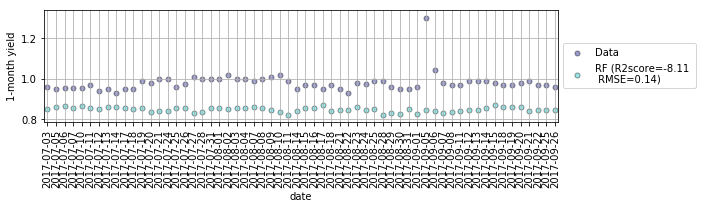

******predicting: 3-month *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3-month  R sq: -2.32674986528
3-month  RMSE: 0.0698215678084


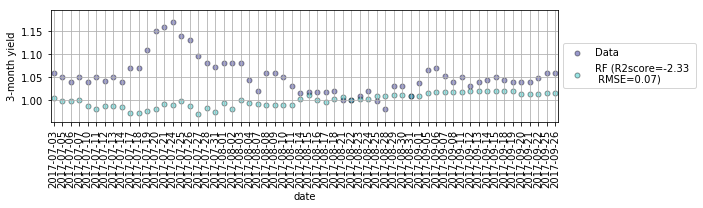

******predicting: 6-month *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


6-month  R sq: -1.0030989039
6-month  RMSE: 0.0357173415867


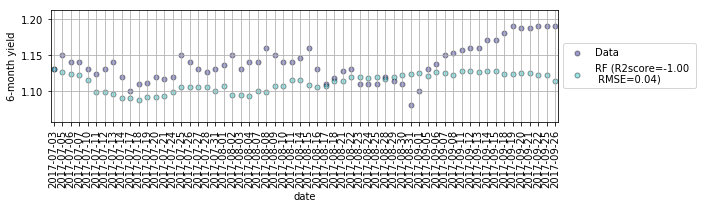

******predicting: 1-year *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1-year  R sq: -1.61379368997
1-year  RMSE: 0.0485928535821


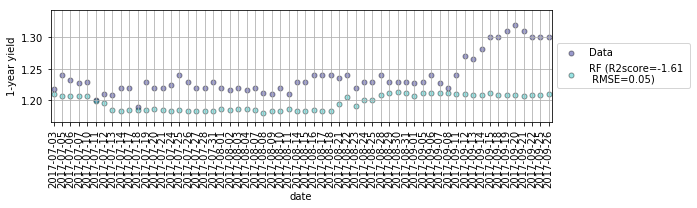

******predicting: 2-year *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2-year  R sq: 0.0618264459568
2-year  RMSE: 0.0394348669921


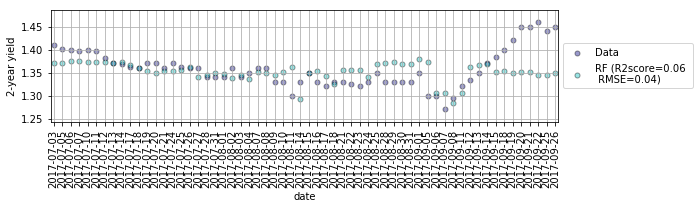

******predicting: 3-year *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3-year  R sq: 0.675730882797
3-year  RMSE: 0.0279259336306


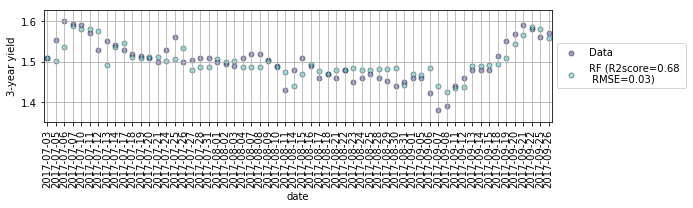

******predicting: 5-year *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


5-year  R sq: 0.754380856496
5-year  RMSE: 0.0359654405693


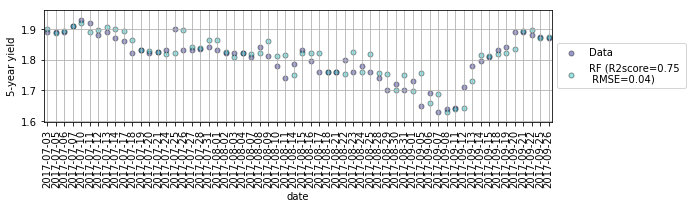

******predicting: 7-year *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


7-year  R sq: 0.85101556964
7-year  RMSE: 0.028572414327


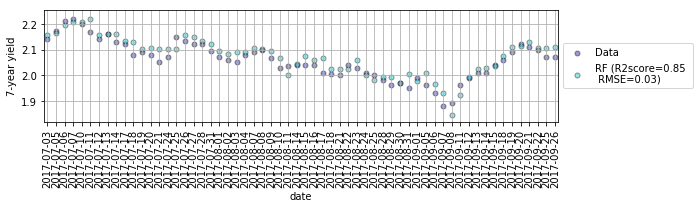

******predicting: 10-year *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


10-year  R sq: 0.853217390804
10-year  RMSE: 0.0300045135859


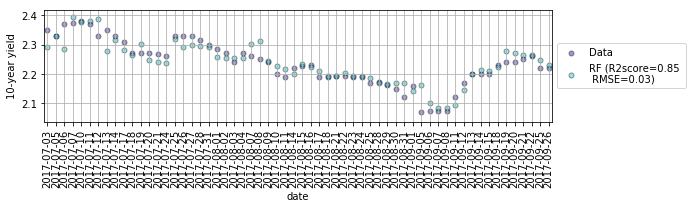

******predicting: 20-year *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


20-year  R sq: 0.835928085677
20-year  RMSE: 0.0280601350206


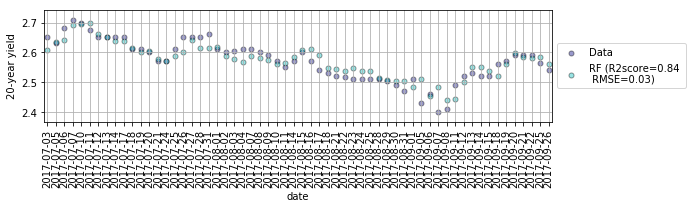

******predicting: 30-year *******
Shapeof Y: (1847, 1)
Shapeof X: (1847, 340)
Shapeof Y_train: (1787, 1)
Shapeof X_train: (1787, 340)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 340)


D:\anaconda_py3\python3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


30-year  R sq: 0.726396667643
30-year  RMSE: 0.0322195235591


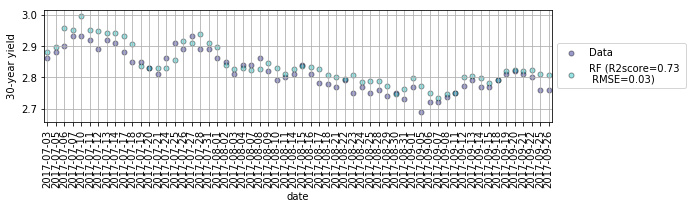

In [65]:
for target in ['1-month', '3-month', '6-month', '1-year', '2-year', '3-year', '5-year','7-year', '10-year', '20-year', '30-year']:
    predictTargetNew(target)

In [71]:
imputed_data.to_csv("MCMC_Imputed_1.csv",index = True)

In [78]:
data.to_csv("missing_0.3.csv")